In [1]:
%load_ext IPython.extensions.autoreload
%autoreload 2

import sys
sys.path.append('..')
from model import FinData
from model import train_valid_split
from model import CatboostFinModel

import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import datetime as dt

c:\Users\Валерия\OneDrive\Документы\GitHub\prices-predictions\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = FinData("../datasets/T_yandex_10min.csv")

In [3]:
data.restrict_time_down(dt.datetime(2024, 8, 1))
data.restrict_time_up(dt.datetime(2024, 9, 30))

In [4]:
windows_ma = [2, 3, 4, 5, 6, 7, 18]
data.insert_rolling_means(windows_ma=windows_ma)
data.get_columns()

Index(['utc', 'open', 'close', 'high', 'low', 'volume', 'direction_binary',
       'ma_2', 'close_normed_ma_2', 'low_normed_ma_2', 'high_normed_ma_2',
       'ma_3', 'close_normed_ma_3', 'low_normed_ma_3', 'high_normed_ma_3',
       'ma_4', 'close_normed_ma_4', 'low_normed_ma_4', 'high_normed_ma_4',
       'ma_5', 'close_normed_ma_5', 'low_normed_ma_5', 'high_normed_ma_5',
       'ma_6', 'close_normed_ma_6', 'low_normed_ma_6', 'high_normed_ma_6',
       'ma_7', 'close_normed_ma_7', 'low_normed_ma_7', 'high_normed_ma_7',
       'ma_18', 'close_normed_ma_18', 'low_normed_ma_18', 'high_normed_ma_18'],
      dtype='object')

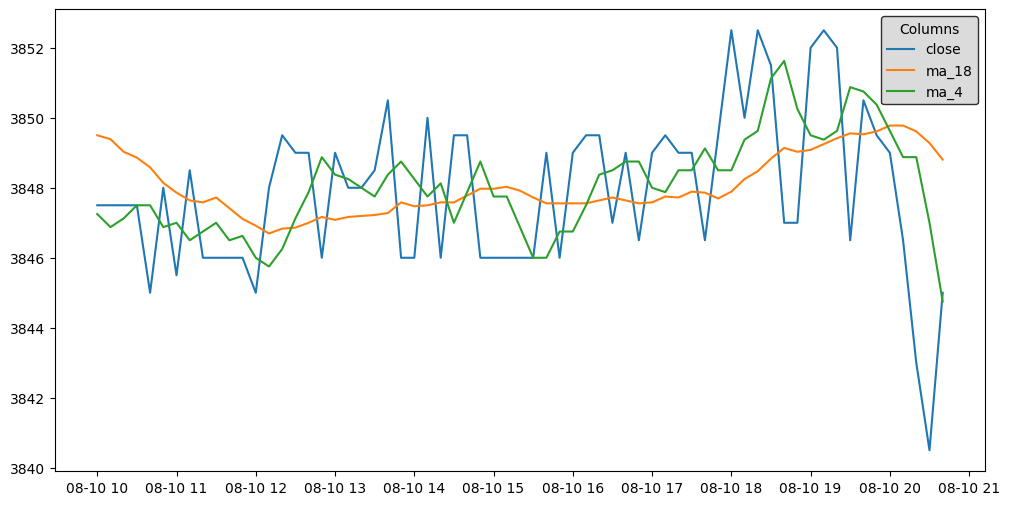

In [5]:
data.visualize_time_frame(datetime_start=dt.datetime(2024, 8, 10, 10), datetime_end=dt.datetime(2024, 8, 11), columns=["close", "ma_18", "ma_4"])

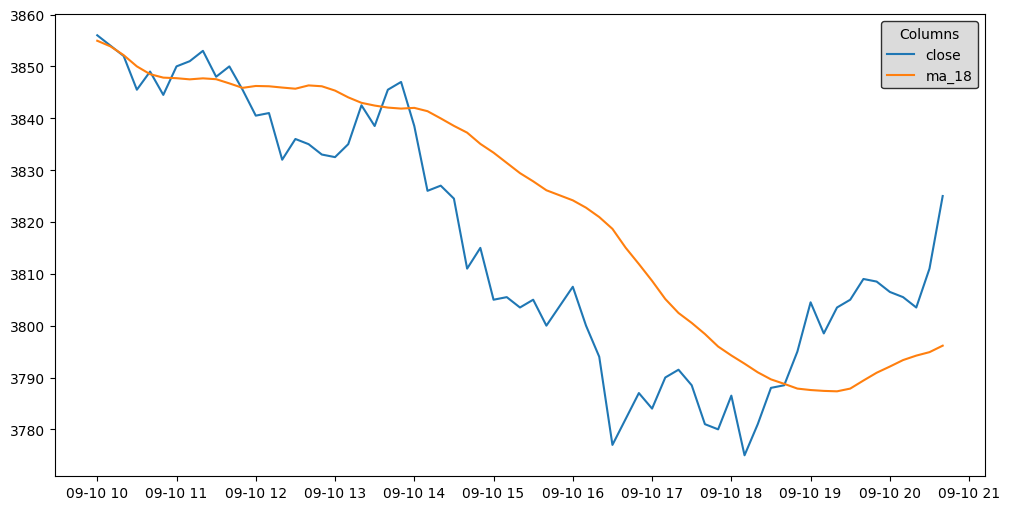

In [6]:
data.visualize_time_frame(datetime_start=dt.datetime(2024, 9, 10, 10), datetime_end=dt.datetime(2024, 9, 11), columns=["close", "ma_18"])

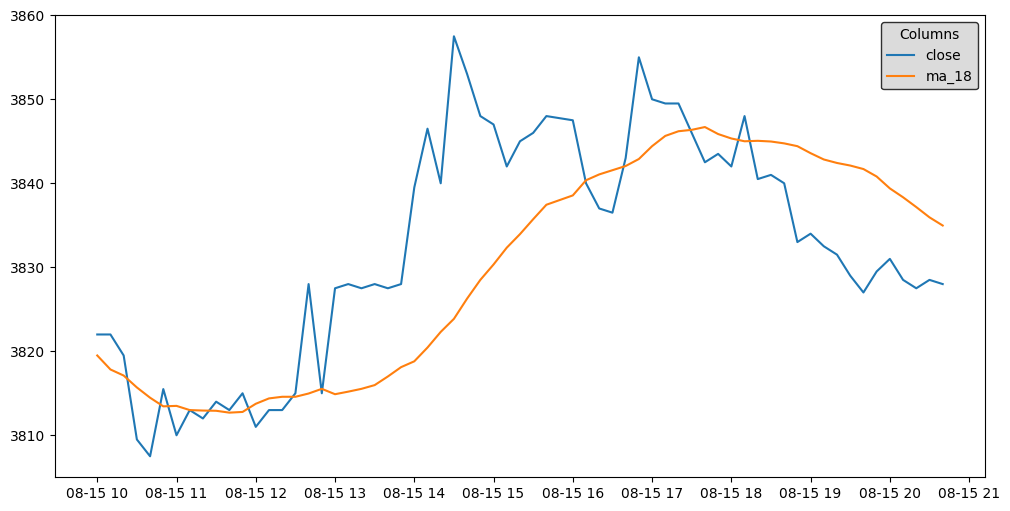

In [7]:
data.visualize_time_frame(datetime_start=dt.datetime(2024, 8, 15, 10), datetime_end=dt.datetime(2024, 8, 16), columns=["close", "ma_18"])

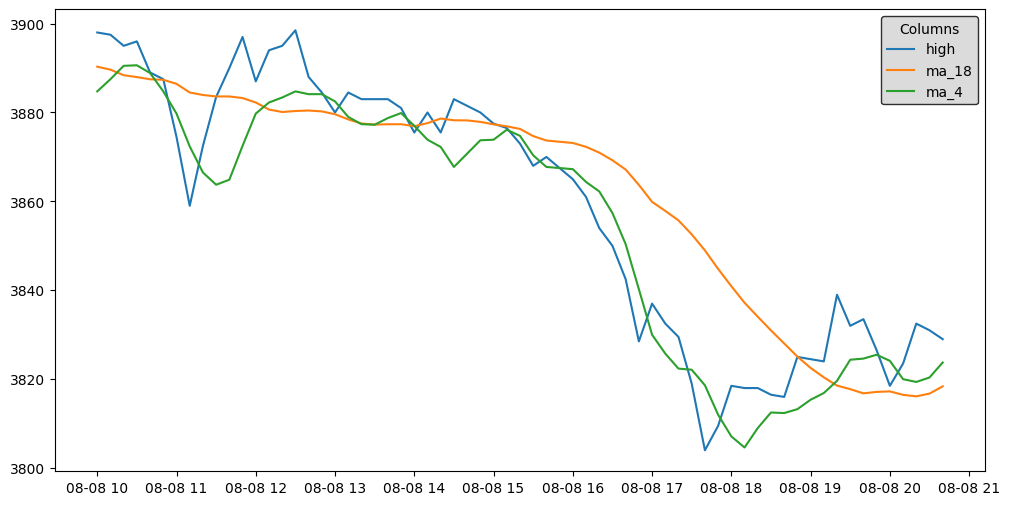

In [8]:
data.visualize_time_frame(datetime_start=dt.datetime(2024, 8, 8, 10), datetime_end=dt.datetime(2024, 8, 9), columns=["high", "ma_18", "ma_4"])

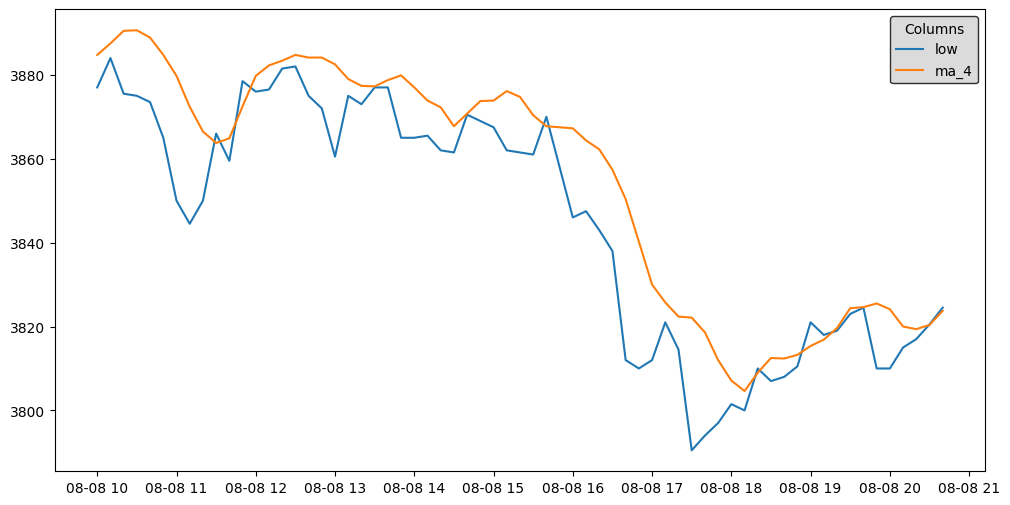

In [9]:
data.visualize_time_frame(datetime_start=dt.datetime(2024, 8, 8, 10), datetime_end=dt.datetime(2024, 8, 9), columns=["low", "ma_4"])

Предположение: Чем более ровная (предсказуемая) прямая скользящего среднего со средним окном сглаживания, тем более хорошую она дает информацию об будущих изменениях.

In [10]:
shift_norms = [2, 3, 4, 5, 6]
windows_ma = [2, 4, 6, 18, 30, 50, 1000]
windows_ema = windows_ma

data = FinData("../datasets/T_yandex_10min.csv")

data.insert_shifts_norms(shift_norms)
data.insert_rolling_means(windows_ma)
data.insert_exp_rolling_means(windows_ma)

In [11]:
numeric = ['high_norms_2', 'low_norms_2', 'close_norms_3', 'high_norms_3',
       'low_norms_3', 'high_norms_4', 'low_norms_4',
       'close_norms_5', 'high_norms_5', 'low_norms_5', 'close_norms_6',
       'high_norms_6', 'low_norms_6', 'close_normed_ma_2', 'close_normed_ma_4', 'close_normed_ma_6',
        'close_normed_ma_18', 'close_normed_ma_30', 'close_normed_ma_50', 'close_normed_ma_1000','close_normed_ema_2', 'close_normed_ema_4',
       'close_normed_ema_6', 'close_normed_ema_18',
       'close_normed_ema_30', 'close_normed_ema_50',
       'close_normed_ema_1000']

cat = []

args = {"iterations" : 10000, 
        "depth" : 5, 
        "learning_rate" : 0.01, # тут слегка неадекватные параметры, которые можно менять 
        "use_best_model" : True, 
        "l2_leaf_reg" : 3,
        "verbose" : 100, # отчет каждые 100 итераций 
        "loss_function" : 'CrossEntropy', 
        "eval_metric" : 'Accuracy', 
        "cat_features" : cat, 
        "random_state" : 42,
        "early_stopping_rounds" : 2000}

In [12]:
data.restrict_time_down(dt.datetime(2024, 7, 1))
data.restrict_time_up(dt.datetime(2024, 8, 9))
X_train, X_val, y_train, y_val = train_valid_split(data=data.df, 
                                                   year=2024, month=8, day=8, 
                                                   numeric=numeric, cat=cat, target="direction_binary")

model = CatboostFinModel(args)

model.set_datasets(X_train, X_val, y_train, y_val)
model.set_features(numeric, cat)

model.fit()

0:	learn: 0.5828794	test: 0.5252525	best: 0.5252525 (0)	total: 121ms	remaining: 20m 7s
100:	learn: 0.6700389	test: 0.5252525	best: 0.5858586 (10)	total: 512ms	remaining: 50.2s
200:	learn: 0.7011673	test: 0.4949495	best: 0.5858586 (10)	total: 868ms	remaining: 42.3s
300:	learn: 0.7346304	test: 0.5050505	best: 0.5858586 (10)	total: 1.22s	remaining: 39.2s
400:	learn: 0.7533074	test: 0.4949495	best: 0.5858586 (10)	total: 1.6s	remaining: 38.3s
500:	learn: 0.7743191	test: 0.4747475	best: 0.5858586 (10)	total: 2.1s	remaining: 39.9s
600:	learn: 0.7914397	test: 0.4646465	best: 0.5858586 (10)	total: 2.45s	remaining: 38.3s
700:	learn: 0.8085603	test: 0.4646465	best: 0.5858586 (10)	total: 2.8s	remaining: 37.1s
800:	learn: 0.8249027	test: 0.4848485	best: 0.5858586 (10)	total: 3.16s	remaining: 36.3s
900:	learn: 0.8389105	test: 0.4545455	best: 0.5858586 (10)	total: 3.54s	remaining: 35.8s
1000:	learn: 0.8505837	test: 0.4545455	best: 0.5858586 (10)	total: 3.94s	remaining: 35.4s
1100:	learn: 0.8715953	te

In [13]:
model.print_constant_accuracy(y_val)

Точность константного предсказания 0.5151515151515151


In [14]:
shift_norms = [2, 3, 4, 5, 6]
windows_ma = [2, 4, 6, 18, 30, 50, 1000]
windows_ema = windows_ma

data = FinData("../datasets/T_yandex_10min.csv")

data.insert_shifts_norms(shift_norms)
data.insert_rolling_means(windows_ma)
data.insert_exp_rolling_means(windows_ma)
data.restrict_time_down(dt.datetime(2024, 7, 1))
data.restrict_time_up(dt.datetime(2024, 8, 9))

In [15]:
data.get_columns()

Index(['utc', 'open', 'close', 'high', 'low', 'volume', 'direction_binary',
       'close_norms_2', 'close_high_norms_2', 'high_norms_2', 'low_norms_2',
       'close_norms_3', 'close_high_norms_3', 'high_norms_3', 'low_norms_3',
       'close_norms_4', 'close_high_norms_4', 'high_norms_4', 'low_norms_4',
       'close_norms_5', 'close_high_norms_5', 'high_norms_5', 'low_norms_5',
       'close_norms_6', 'close_high_norms_6', 'high_norms_6', 'low_norms_6',
       'ma_2', 'close_normed_ma_2', 'low_normed_ma_2', 'high_normed_ma_2',
       'ma_4', 'close_normed_ma_4', 'low_normed_ma_4', 'high_normed_ma_4',
       'ma_6', 'close_normed_ma_6', 'low_normed_ma_6', 'high_normed_ma_6',
       'ma_18', 'close_normed_ma_18', 'low_normed_ma_18', 'high_normed_ma_18',
       'ma_30', 'close_normed_ma_30', 'low_normed_ma_30', 'high_normed_ma_30',
       'ma_50', 'close_normed_ma_50', 'low_normed_ma_50', 'high_normed_ma_50',
       'ma_1000', 'close_normed_ma_1000', 'low_normed_ma_1000',
       'high_

In [16]:
data.print_correlations(columns=numeric)

Корреляции столбцов с колонкой 'direction_binary':
close_normed_ma_2       -0.079844
close_normed_ema_2      -0.078066
close_normed_ma_4       -0.076494
close_normed_ema_4      -0.075155
close_normed_ema_6      -0.067202
close_norms_3           -0.066959
close_normed_ma_6       -0.064979
close_norms_6           -0.048756
close_normed_ema_18     -0.044925
low_norms_6             -0.044449
high_norms_3            -0.044291
low_norms_3             -0.044152
close_normed_ema_30     -0.038968
close_normed_ma_50      -0.037755
low_norms_2             -0.037672
close_norms_5           -0.035224
close_normed_ma_18      -0.034473
close_normed_ma_30      -0.034431
high_norms_4            -0.030424
close_normed_ema_50     -0.028694
high_norms_6            -0.026226
low_norms_5             -0.025858
low_norms_4             -0.020511
high_norms_5            -0.020089
high_norms_2            -0.018340
close_normed_ema_1000    0.019006
close_normed_ma_1000     0.019193
Name: direction_binary, dtype: 

In [17]:
new_cols = ['close_normed_ma_2', 'low_normed_ma_2', 'high_normed_ma_2',
            'close_normed_ma_4', 'low_normed_ma_4', 'high_normed_ma_4',
            'close_normed_ma_6', 'low_normed_ma_6', 'high_normed_ma_6',
            'close_normed_ma_18', 'low_normed_ma_18', 'high_normed_ma_18',
            'close_normed_ma_30', 'low_normed_ma_30', 'high_normed_ma_30',
            'close_normed_ma_50', 'low_normed_ma_50', 'high_normed_ma_50']

In [18]:
data.print_correlations(columns=new_cols)

Корреляции столбцов с колонкой 'direction_binary':
close_normed_ma_2    -0.079844
close_normed_ma_4    -0.076494
close_normed_ma_6    -0.064979
low_normed_ma_2      -0.063779
low_normed_ma_4      -0.061976
low_normed_ma_6      -0.052054
close_normed_ma_50   -0.037755
close_normed_ma_18   -0.034473
close_normed_ma_30   -0.034431
low_normed_ma_50     -0.032386
low_normed_ma_30     -0.027860
low_normed_ma_18     -0.026076
high_normed_ma_50    -0.019112
high_normed_ma_4     -0.018768
high_normed_ma_6     -0.016024
high_normed_ma_2     -0.012978
high_normed_ma_30    -0.011868
high_normed_ma_18    -0.006119
Name: direction_binary, dtype: float64


In [19]:
new_cols = ['low_normed_ma_2', 
            'low_normed_ma_4', 
            'low_normed_ma_6', 
            'low_normed_ma_18', 
            'low_normed_ma_30', 
            'low_normed_ma_50']

numeric = ['low_norms_2', 'close_norms_3', 'high_norms_3',
       'low_norms_3', 'high_norms_4', 'low_norms_4',
       'close_norms_5', 'low_norms_5', 'close_norms_6',
       'high_norms_6', 'low_norms_6', 'close_normed_ma_2', 'close_normed_ma_4', 'close_normed_ma_6',
        'close_normed_ma_18', 'close_normed_ma_30', 'close_normed_ma_50','close_normed_ema_2', 'close_normed_ema_4', 'close_normed_ema_18',
       'close_normed_ema_30', 'close_normed_ema_50']

args = {"iterations" : 10000, 
        "depth" : 5, 
        "learning_rate" : 0.03, # тут слегка неадекватные параметры, которые можно менять 
        "use_best_model" : True, 
        "l2_leaf_reg" : 100,
        "verbose" : 100, # отчет каждые 100 итераций 
        "loss_function" : 'CrossEntropy', 
        "eval_metric" : 'Accuracy', 
        "cat_features" : cat, 
        "random_state" : 42,
        "early_stopping_rounds" : 6000}

numeric = numeric + new_cols

In [20]:
shift_norms = [2, 3, 4, 5, 6]
windows_ma = [2, 4, 6, 18, 30, 50, 1000]
windows_ema = windows_ma

data = FinData("../datasets/T_yandex_10min.csv")

data.insert_shifts_norms(shift_norms)
data.insert_rolling_means(windows_ma)
data.insert_exp_rolling_means(windows_ma)
data.restrict_time_down(dt.datetime(2024, 7, 1))
data.restrict_time_up(dt.datetime(2024, 8, 9))

In [21]:
model = CatboostFinModel(args)

model.set_features(numeric, cat)
X_train, X_val, y_train, y_val = train_valid_split(data=data.df, 
                                                   year=2024, month=8, day=8, 
                                                   numeric=numeric, cat=cat, target="direction_binary")
         
model.set_datasets(X_train, X_val, y_train, y_val)
model.fit()

0:	learn: 0.5961089	test: 0.5252525	best: 0.5252525 (0)	total: 7.74ms	remaining: 1m 17s
100:	learn: 0.6490272	test: 0.5656566	best: 0.5656566 (2)	total: 434ms	remaining: 42.5s
200:	learn: 0.6894942	test: 0.5353535	best: 0.5656566 (2)	total: 1.07s	remaining: 52.3s
300:	learn: 0.7252918	test: 0.5151515	best: 0.5656566 (2)	total: 2.31s	remaining: 1m 14s
400:	learn: 0.7688716	test: 0.5454545	best: 0.5656566 (2)	total: 2.85s	remaining: 1m 8s
500:	learn: 0.8015564	test: 0.5555556	best: 0.5656566 (2)	total: 3.33s	remaining: 1m 3s
600:	learn: 0.8233463	test: 0.5454545	best: 0.5656566 (2)	total: 3.87s	remaining: 1m
700:	learn: 0.8420233	test: 0.5151515	best: 0.5656566 (2)	total: 4.32s	remaining: 57.3s
800:	learn: 0.8677043	test: 0.4747475	best: 0.5656566 (2)	total: 5.13s	remaining: 58.9s
900:	learn: 0.8848249	test: 0.4848485	best: 0.5656566 (2)	total: 5.65s	remaining: 57.1s
1000:	learn: 0.8980545	test: 0.4949495	best: 0.5656566 (2)	total: 6.03s	remaining: 54.2s
1100:	learn: 0.9035019	test: 0.50

In [22]:
model.print_feature_importances()

0.0 close_normed_ma_6
0.0 low_normed_ma_6
0.0 low_normed_ma_4
0.0 low_normed_ma_2
0.0 close_normed_ema_50
0.0 close_normed_ema_30
0.0 close_normed_ema_2
0.0 close_normed_ma_30
0.0 close_normed_ma_18
0.0 close_normed_ma_2
0.0 low_normed_ma_50
0.0 close_norms_3
0.0 close_norms_6
0.0 low_norms_5
0.0 close_norms_5
0.0 low_norms_6
2.377144224997293 low_norms_4
3.3803813296341856 low_normed_ma_18
3.5375305200673197 high_norms_6
3.6790050081647934 low_norms_3
3.7425859402369936 low_norms_2
4.067411431706185 high_norms_4
4.916049876476628 high_norms_3
9.012964806790816 close_normed_ma_50
11.29960993201306 low_normed_ma_30
12.118180394330539 close_normed_ma_4
19.281177120235608 close_normed_ema_18
22.58795941534657 close_normed_ema_4


In [28]:
shift_norms = [2, 3, 4, 5, 6]
windows_ma = [2, 4, 6, 18, 30, 50, 1000]
windows_ema = windows_ma

data = FinData("../datasets/T_yandex_10min.csv")

data.insert_shifts_norms(shift_norms)
data.insert_rolling_means(windows_ma)
data.insert_exp_rolling_means(windows_ma)

In [29]:
data.restrict_time_down(dt.datetime(2024, 6, 1))
data.restrict_time_up(dt.datetime(2024, 9, 11))
X_train, X_val, y_train, y_val = train_valid_split(data=data.df, 
                                                   year=2024, month=9, day=10, 
                                                   numeric=numeric, cat=cat, target="direction_binary")

model.set_features(numeric, cat)
model.set_datasets(X_train, X_val, y_train, y_val)

model.fit()

0:	learn: 0.5767840	test: 0.5555556	best: 0.5555556 (0)	total: 3.96ms	remaining: 39.6s
100:	learn: 0.6007612	test: 0.5656566	best: 0.5656566 (86)	total: 821ms	remaining: 1m 20s
200:	learn: 0.6232160	test: 0.5959596	best: 0.5959596 (174)	total: 1.44s	remaining: 1m 10s
300:	learn: 0.6445290	test: 0.6060606	best: 0.6161616 (238)	total: 2.2s	remaining: 1m 11s
400:	learn: 0.6685062	test: 0.5858586	best: 0.6161616 (238)	total: 2.83s	remaining: 1m 7s
500:	learn: 0.6871551	test: 0.5555556	best: 0.6161616 (238)	total: 3.83s	remaining: 1m 12s


: 

In [25]:
model.print_constant_accuracy(y_val)

Точность константного предсказания 0.5151515151515151


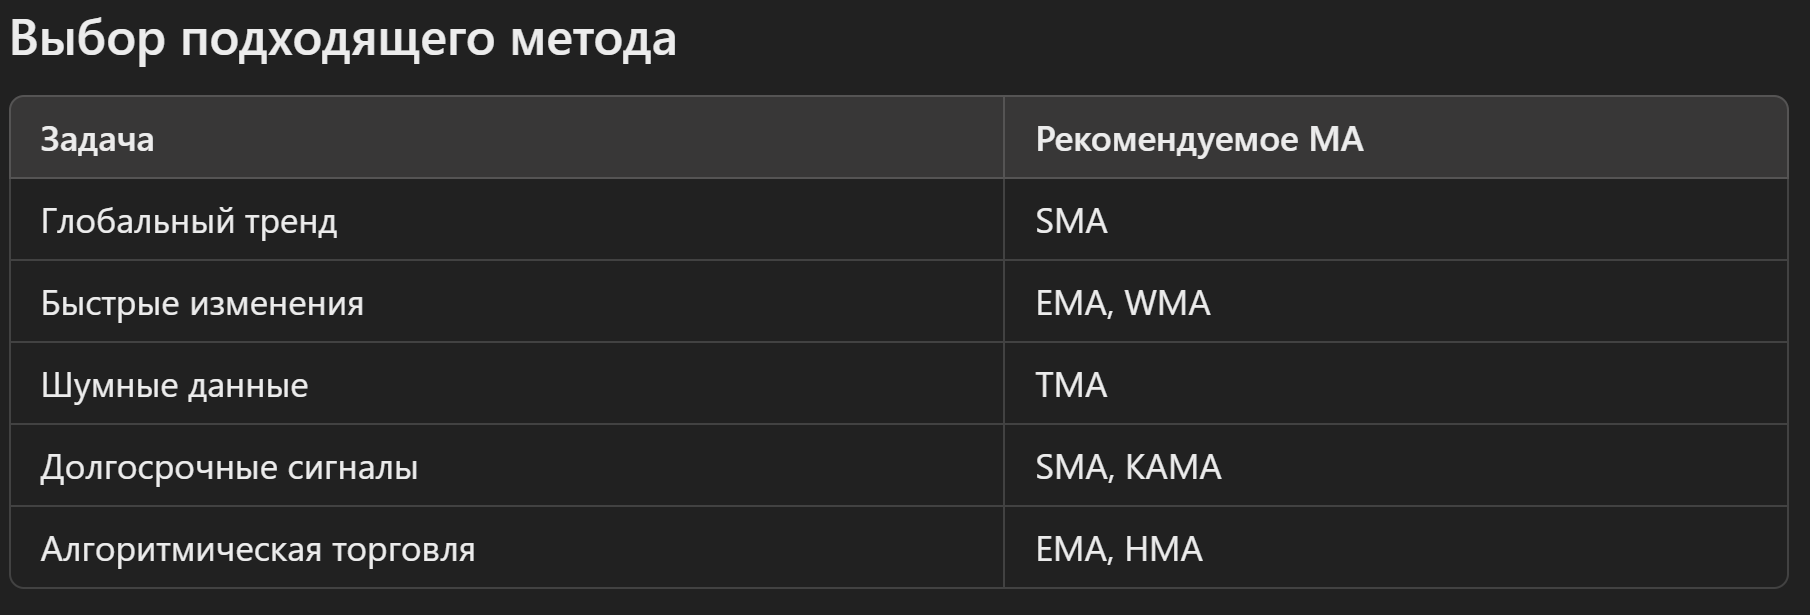

In [26]:
data.insert_weighted_rolling_means(windows_wma=[4])
data.df.wma_4

[1 2 3 4]


0           NaN
1           NaN
2           NaN
3       4231.55
4       4226.80
         ...   
4611    3807.45
4612    3806.75
4613    3805.20
4614    3807.20
4615    3814.55
Name: wma_4, Length: 4616, dtype: float64

In [27]:
data.df.close

0       4263.0
1       4227.0
2       4239.5
3       4220.0
4       4225.5
         ...  
4611    3806.5
4612    3805.5
4613    3803.5
4614    3811.0
4615    3825.0
Name: close, Length: 4616, dtype: float64

#### LOESS